# Vectorized Code for Project 2

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cProfile
import scipy.sparse.linalg
import scipy.sparse

In [2]:
%matplotlib notebook

### Mesh Generator

In [3]:
from getdisc import GetDisc, NodalPoints, FreeBoundary, CircleData
from getplate import getPlate
from getlshape import GetLShape

## p=1 elements on simplexes implementation

First, we create a gradient function, which creates a gradient array for each element.

In [4]:
def vec_cross_product(p1,p2,p3):
    #pi for i=1,2,3 is the arrray containing the x,y coordinates of the i-th point in each simplex
    P = p1-p3
    Q = p2-p3
    
    cross = P[:,0]*Q[:,1]-P[:,1]*Q[:,0]
    cross_product = np.abs(cross)
    
    return cross_product

In [5]:
def vec_gradient(p1,p2,p3):
    # p1 - the [x,y] coordinates of the first entry of every simplex in the mesh
    # p2 - the [x,y] coordinates of the first entry of every simplex in the mesh
    # p3 - the [x,y] coordinates of the first entry of every simplex in the mesh
    # N_i = 1/(2A) * (alpha_i + beta_i * x + gamma_i * y)
    # The coefficients are precomputed so that we avoid solving a linear system of equations to compute the coeffs
    beta = np.array([p2[:,1]-p3[:,1], p3[:,1]- p1[:,1], p1[:,1]-p2[:,1]])
    gamma = np.array([p3[:,0]-p2[:,0], p1[:,0]-p3[:,0], p2[:,0]-p1[:,0]])
    area = vec_cross_product(p1,p2,p3)
    const = 1 / area
    arr = np.array([beta,gamma])*const
    return arr

We also need a way to compute the cross_product. We implement a vectorized version of it below.

### Stiffness matrix

In [6]:
def StiffnessMatrixP1(p,tri,p_tri,N):
    # Function which creates the stiffness matrix
    # for a triangulation with N nodes
    
    J = np.repeat(tri, 3, axis=1).flatten() #i index array
    I = np.hstack([tri]*3).flatten() #j index array

    #Extracting x,y coordinates of the first, second and third element in each simplex
    p1 = p_tri[:,0:2]
    p2 = p_tri[:,2:4]
    p3 = p_tri[:,4:6]
    
    arr = vec_gradient(p1,p2,p3)
    arr = arr.reshape(6,-1).transpose()

    grad = arr.reshape(-1, 2,3) #Collecting the different gradient from different elements in their own arrays

    gradT = grad.transpose(0,2,1)

    grad_squared = gradT @ grad #Computing the integrands
    
    area = 1/2 * vec_cross_product(p1,p2,p3)
    area = np.repeat(area, 9).reshape(-1,3,3)
    
    grad_squared *= area # Computing the integral
    
    U = grad_squared.reshape(-1,9).flatten() # Computing the entries of our stiffness matrix
    
    spA = scipy.sparse.coo_matrix((U, (I, J)), shape=(N,N)) #Creating a sparse version of our stiffness matrix
    return spA

### Load Vector

In order to build the load vector, we need to compute the nodal basis functions $N_i$ for $i=1,2,3$. Here we express these functions using our usual $x,y$ coordinate system.

In [7]:
def NodalBasisFunctionsP1(p1,p2,p3):
    #Compute the area(actually twice the area) for each element
    area = vec_cross_product(p1,p2,p3)
    area = np.repeat(area, 3).reshape(-1,3)

    #Here there is a correspondance between i=1, j=2, m=3. This is just the notation used in a note we found
    xi = p1[:,0]; xj = p2[:,0]; xm = p3[:,0]
    yi = p1[:,1]; yj = p2[:,1]; ym = p3[:,1]
    
    #Computing the coeffients for our nodal basis functions
    alphai = xj*ym-yj*xm; alphaj = xm*yi - ym*xi; alpham = xi*yj - yi*xj
    betai = yj - ym; betaj = ym - yi; betam = yi-yj
    gammai = xm - xj; gammaj = xi - xm; gammam = xj-xi
    
    #Grouping coeefs togethet   
    alpha = np.array([alphai, alphaj, alpham]).transpose()
    beta = np.array([betai, betaj, betam]).transpose()
    gamma = np.array([gammai, gammaj, gammam]).transpose()
    
    #Creating a function for the basis functions
    func = lambda x,y: 1/area * (alpha + beta*x + gamma*y)
    
    return func #Returning the function

Now we are ready to define our load vector.

In [8]:
def LoadVectorP1(p,tri,p_tri,N, f):
    # N is number of nodes in the triangulation
    # f is the right hand side
      
    cross_prod = vec_cross_product(p_tri[:,0:2],p_tri[:,2:4],p_tri[:,4:6])
    
    #Using the three point Gauss rule
    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]]) # Definining the interpolation points
    pq = np.ones(3)/3 # Defining the weights
    
    # Finding the cartesian coordinates x,y for the points to evaluate the integrand at
    x = np.outer(p_tri[:,0],zq[:,0]) + np.outer(p_tri[:,2],zq[:,1]) + np.outer(p_tri[:,4],zq[:,2])
    y = np.outer(p_tri[:,1], zq[:,0]) + np.outer(p_tri[:,3],zq[:,1]) + np.outer(p_tri[:,5],zq[:,2])
        
    g = NodalBasisFunctionsP1(p_tri[:,0:2],p_tri[:,2:4],p_tri[:,4:6])
    h = lambda x,y: f(x,y)*g(x,y) # The integrand
    #Computing the actual integral expression
    res = cross_prod * np.sum(pq * h(x,y),1) / 2 
    #res = np.sum(pq * h(x,y),1)
    #Accounting one entry for each node in each element
    res = np.repeat(res.reshape(-1,1), 3,1).flatten()
    
    #Accounting for duplicate entries. Inspired by some code on stackexchange
    idx = tri.flatten() #Finding the indices
    unq, st, ids = np.unique(idx, return_index=1, return_inverse=1)
    F = np.bincount(ids, res) # Summing together duplicates
    
    return F

Defining the right-hand side of our equation.

In [9]:
f_disc = lambda x,y: -8*np.pi*np.cos(2*np.pi*(x**2+y**2)) + 16*np.pi**2*(x**2 + y**2)*np.sin(2*np.pi*(x**2 + y**2))

Defining the exact solution to our equation

In [10]:
u_ex_disc = lambda x,y: np.sin(2*np.pi*(x**2 + y**2))

## The Solver

In [11]:
#We solve the system with boundary conditions directly

def Laplace2DSolverP1(N, f):
    
    p,tri,edge = GetDisc(N)

    #Finding coordinates for each point in each simplex
    p_tri = p[tri]
    p_tri = p_tri.reshape(-1,6)

    #Makes the matrix without considering the boundary
    Atilde =  StiffnessMatrixP1(p,tri,p_tri,N)
    
    #Makes the right hand side without considering the boundary
    Ftilde = LoadVectorP1(p,tri,p_tri,N, f)
    
    #Define the size the reduced system will have, N - #boundary-nodes
    intN = N - np.size(edge,0)
    
    #Convert our sparse matrix to another format
    spAtilde = scipy.sparse.csr_matrix(Atilde)
    
    #Slicing away the boundary points
    spA = spAtilde[:intN, :intN]
    F = Ftilde[:intN]
    
    #Solve the system
    u = scipy.sparse.linalg.spsolve(spA,F)
    
    return u

## Verification

         1024 function calls (1017 primitive calls) in 0.373 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.121    0.121    0.121    0.121 {built-in method scipy.sparse.linalg.dsolve._superlu.gssv}
        1    0.101    0.101    0.202    0.202 getdisc.py:20(GetDisc)
        1    0.094    0.094    0.098    0.098 getdisc.py:41(NodalPoints)
        1    0.006    0.006    0.006    0.006 {built-in method scipy.sparse._sparsetools.csr_sort_indices}
        1    0.005    0.005    0.005    0.005 833683809.py:1(<lambda>)
        4    0.005    0.001    0.005    0.001 3744284859.py:1(vec_cross_product)
        4    0.004    0.001    0.004    0.001 {method 'repeat' of 'numpy.ndarray' objects}
        3    0.004    0.001    0.004    0.001 {built-in method numpy.zeros}
        1    0.004    0.004    0.004    0.004 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.003    0.003    0.015    0.015 2746488744.py:1(S

<IPython.core.display.Javascript object>


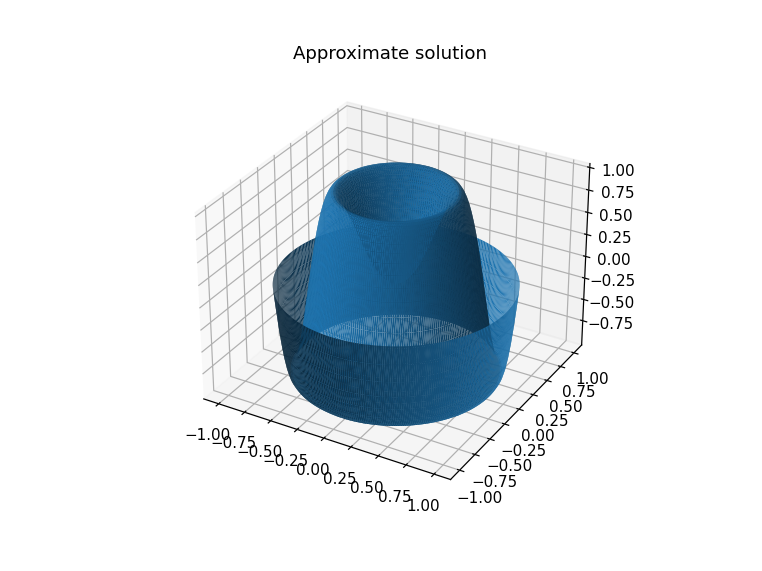

<IPython.core.display.Javascript object>


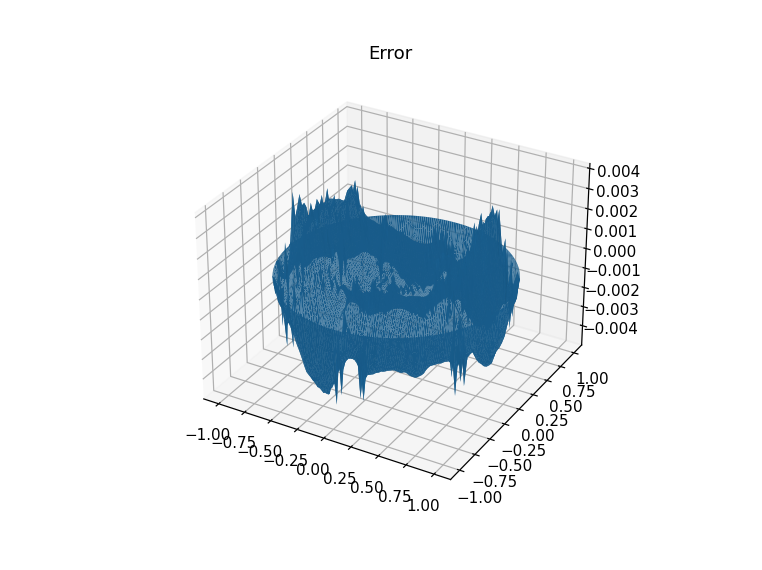

Text(0.5, 0.92, 'Error')

In [12]:
N = 10000

#Running the profiler
prof = cProfile.run("Laplace2DSolverP1(N, f_disc)", sort="tottime")
# Computing our approximate solution
p,tri,edge = GetDisc(N)
u = Laplace2DSolverP1(N, f_disc)
u_w_boundary = np.zeros(len(p))
u_w_boundary[:len(u)] = u
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_trisurf(p[:,0],p[:,1],u_w_boundary)
ax.set_title('Approximate solution')

#Plotting the difference.
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_trisurf(p[:,0],p[:,1],u_ex_disc(p[:,0],p[:,1])-u_w_boundary)
ax.set_title('Error')
#fig.savefig('2_8_error.pdf')

# p=2 elements on simplexes

Let us begin by definining our T6 elements

In [13]:
#Viktig å vite om denne biten i det hele tatt er riktig
def T6_elements(p, tri,edges):
    N = len(p)
    p_tri = p[tri]
    p_tri = p_tri.reshape(-1,6)
    p1 = p_tri[:,0:2]; p2 = p_tri[:,2:4]; p3 = p_tri[:,4:6]
    p4 = (p1+p2)/2
    p5 = (p2+p3)/2
    p6 = (p1+p3)/2
    new_p = np.array([p4,p5,p6])
    new_p = new_p.transpose((1,0,2))
    new_p = new_p.reshape(-1,2)
    unq, idx, inv = np.unique(new_p, return_index=True,return_inverse=True, axis=0)
    inv = inv.reshape(-1,3)
    inv += N
    T6 = np.zeros((tri[:,0].size, 6), dtype=int)
    T6[:,0:3] = tri
    T6[:,3:6] = inv

    pn = np.concatenate((p, unq))
    
    boundary_middle_nodes = []
    edge1 = tri[:,0:2]
    edge2 = tri[:,1:3]
    edge3 = tri[:,[2,0]]
    for edgei in edges:
        for k ,sub_edges in enumerate([edge1, edge2, edge3]):
            try:
                index = np.where((sub_edges[:,0]==edgei[0]) & (sub_edges[:,1]==edgei[1]))[0][0]
                boundary_middle_nodes.append(T6[index, 3+k])
            except:
                pass
    boundary_middle_nodes = np.asarray(boundary_middle_nodes)
    boundary_middle_nodes = np.unique(boundary_middle_nodes)
    return pn, T6, edge, boundary_middle_nodes

In [14]:
#ref: https://stackoverflow.com/questions/13077527/is-there-a-numpy-delete-equivalent-for-sparse-matrices
def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

def delete_cols_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[1], dtype=bool)
    mask[indices] = False
    return mat[:,mask]

In [15]:
def vec_gradients(p1,p2,p3):
    #Here there is a correspondance between i=1, j=2, m=3. This is just the notation used in a note we found
    xi = p1[:,0]; xj = p2[:,0]; xm = p3[:,0]
    yi = p1[:,1]; yj = p2[:,1]; ym = p3[:,1]

    #Computing the coeffients for our nodal basis functions
    alphai = xj*ym-yj*xm; alphaj = xm*yi - ym*xi; alpham = xi*yj - yi*xj
    betai = yj - ym; betaj = ym - yi; betam = yi-yj
    gammai = xm - xj; gammaj = xi - xm; gammam = xj-xi

    A = 1/2 * vec_cross_product(p1,p2,p3) #Area 

    #Using the three point Gauss rule
    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]]) # Definining the interpolation points
    pq = np.zeros(3)/3

    # Finding the cartesian coordinates x,y for the points to evaluate the integrand at
    x = np.outer(xi,zq[:,0]) + np.outer(xj,zq[:,1]) + np.outer(xm,zq[:,2])
    y = np.outer(yi, zq[:,0]) + np.outer(yj,zq[:,1]) + np.outer(ym,zq[:,2])
    
    #Reshaping x and y so that my functions don't get mad at me
    x = x.T; y = y.T
    #Shit just magically worked itself out. Fucking beautiful.

    #Let us compute some partial derivatives. Probably problems when we try to evaluate for array values of x and y
    N1x = lambda x,y: 1/A**2 * (alphai*betai + betai*betai*x + gammai*betai*y) - betai / (2*A)
    N2x = lambda x,y: 1/A**2 * (alphaj*betaj + betaj*betaj*x + gammaj*betaj*y) - betaj / (2*A)
    N3x = lambda x,y: 1/A**2 * (alpham*betam + betam*betam*x + gammam*betam*y) - betam / (2*A)
    N4x = lambda x,y: 1/A**2 * (alphaj*betai + betaj*betai*x + gammaj*betai*y) + 1/A**2 * (alphai*betaj + betai*betaj*x + gammai*betaj*y)
    N5x = lambda x,y: 1/A**2 * (alpham*betaj + betam*betaj*x + gammam*betaj*y) + 1/A**2 * (alphaj*betam + betaj*betam*x + gammaj*betam*y)
    N6x = lambda x,y: 1/A**2 * (alpham*betai + betam*betai*x + gammam*betai*y) + 1/A**2 * (alphai*betam + betai*betam*x + gammai*betam*y)

    N1y = lambda x,y: (1/(A**2)) * (alphai*gammai + betai*gammai*x + gammai*gammai*y) - gammai / (2*A)
    N2y = lambda x,y: (1/(A**2)) * (alphaj*gammaj + betaj*gammaj*x + gammaj*gammaj*y) - gammaj / (2*A)
    N3y = lambda x,y: (1/(A**2)) * (alpham*gammam + betam*gammam*x + gammam*gammam*y) - gammam / (2*A)
    N4y = lambda x,y: (1/(A**2)) * (alphaj*gammai + betaj*gammai*x + gammaj*gammai*y) + 1/A**2 * (alphai*gammaj + betai*gammaj*x + gammai*gammaj*y)
    N5y = lambda x,y: (1/(A**2)) * (alpham*gammaj + betam*gammaj*x + gammam*gammaj*y) + 1/A**2 * (alphaj*gammam + betaj*gammam*x + gammaj*gammam*y)
    N6y = lambda x,y: (1/(A**2)) * (alpham*gammai + betam*gammai*x + gammam*gammai*y) + 1/A**2 * (alphai*gammam + betai*gammam*x + gammai*gammam*y)
    
    Nx = np.array([N1x(x,y), N2x(x,y), N3x(x,y), N4x(x,y), N5x(x,y), N6x(x,y)])
    Ny = np.array([N1y(x,y), N2y(x,y), N3y(x,y), N4y(x,y), N5y(x,y), N6y(x,y)])
    gradN = np.array([Nx, Ny])
    return gradN

In [16]:
def StiffnessMatrixP2(p, tri, pnew, tri6):
    length = len(tri)*6*6
    Arr = np.zeros((length, 3))
    
    p_tri = p[tri]
    p_tri = p_tri.reshape(-1, 6)
    p1 = p_tri[:,0:2]; p2 = p_tri[:, 2:4]; p3 = p_tri[:,4:6]

    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]])
    pq = np.ones(3)/3 # Defining the weights

    
    grad = vec_gradients(p1,p2,p3).transpose(-1, 0,1,2)
    grad = grad.transpose(-1, 0, 1, 2)
    gradT = grad.transpose(0,1,3,2)
    grad_squared = gradT @ grad
    grad_squared = grad_squared.transpose(1,2,3,0)
    grad_squared = np.sum(pq*grad_squared, axis=-1)
    grad_squared = grad_squared.reshape(-1, 36)

    area = 1/2 * vec_cross_product(p1,p2,p3)

    grad_squared *= area.reshape(-1,1)
    U = grad_squared.flatten()
    
    J = np.repeat(tri6, 6, axis=1).flatten() #i index array
    I = np.hstack([tri6]*6).flatten() #j index array
    M = pnew[:,0].size
    spA = scipy.sparse.coo_matrix((U, (I, J)), shape=(M,M)) #Creating a sparse version of our stiffness matrix
    return spA

In [17]:
def LoadVectorP2(p, tri, tri1,f):
    p_tri = p[tri]
    p_tri = p_tri.reshape(-1,6)
    p1 = p_tri[:,0:2]; p2 = p_tri[:,2:4]; p3 = p_tri[:,4:6]

    #Here there is a correspondance between i=1, j=2, m=3. This is just the notation used in a note we found
    xi = p1[:,0]; xj = p2[:,0]; xm = p3[:,0]
    yi = p1[:,1]; yj = p2[:,1]; ym = p3[:,1]

    #Computing the coeffients for our nodal basis functions
    alphai = xj*ym-yj*xm; alphaj = xm*yi - ym*xi; alpham = xi*yj - yi*xj
    betai = yj - ym; betaj = ym - yi; betam = yi-yj
    gammai = xm - xj; gammaj = xi - xm; gammam = xj-xi

    A = 1/2 * vec_cross_product(p1,p2,p3) #Area

    #Using the three point Gauss rule
    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]]) # Definining the interpolation points
    pq = np.ones(3)/3 # Defining the weights

    # Finding the cartesian coordinates x,y for the points to evaluate the integrand at
    x = np.outer(p_tri[:,0],zq[:,0]) + np.outer(p_tri[:,2],zq[:,1]) + np.outer(p_tri[:,4],zq[:,2])
    y = np.outer(p_tri[:,1], zq[:,0]) + np.outer(p_tri[:,3],zq[:,1]) + np.outer(p_tri[:,5],zq[:,2])

    #Reshaping x and y so that my functions don't get mad at me
    x = x.T; y = y.T

    #Need nodal functions for T6 elements
    N1 = lambda x,y: 1 / (2*A) * (alphai + betai*x + gammai*y) * (1/A * (alphai + betai*x + gammai*y) - 1)
    N2 = lambda x,y: 1 / (2*A) * (alphaj + betaj*x + gammaj*y) * (1/A * (alphaj + betaj*x + gammaj*y) - 1)
    N3 = lambda x,y: 1 / (2*A) * (alpham + betam*x + gammam*y) * (1/A * (alpham + betam*x + gammam*y) - 1)
    N4 = lambda x,y: 1 / A**2  * (alphai + betai*x + gammai*y) * (alphaj + betaj*x + gammaj*y)
    N5 = lambda x,y: 1 / A**2  * (alphaj + betaj*x + gammaj*y) * (alpham + betam*x + gammam*y)
    N6 = lambda x,y: 1 / A**2  * (alphai + betai*x + gammai*y) * (alpham + betam*x + gammam*y)

    N = lambda x,y: np.array([N1(x,y), N2(x,y), N3(x,y), N4(x,y), N5(x,y), N6(x,y)])
    h = f(x,y)*N(x,y)
    h = h.transpose(0,2,1)
    res = np.sum(pq*h,2)
 
    res *= A
    res = res.transpose().flatten()

    idx = tri1.flatten() #Finding the indices

    unq, st, ids = np.unique(idx, return_index=1, return_inverse=1)
    F = np.bincount(ids, res) # Summing together duplicates
    
    return F

In [18]:
def Laplace2DSolverP2(N,f):
    p,tri,edge = GetDisc(N)
    p1, tri1, edge1, boundary_middle_nodes = T6_elements(p, tri, edge)
    
    #Makes the matrix without considering the boundary
    spAtilde = StiffnessMatrixP2(p, tri, p1, tri1)
    
    #Makes the right hand side without considering the boundary
    Ftilde = LoadVectorP2(p, tri, tri1, f)
    
    #Define the size the reduced system will have, N - #boundary-nodes
    intN = N - np.size(edge,0)
    
    #Removing boundary nodes
    spAtilde = scipy.sparse.csr_matrix(spAtilde)
    spA = delete_rows_csr(spAtilde, boundary_middle_nodes)
    spA = delete_cols_csr(spA, boundary_middle_nodes)
    spA = delete_rows_csr(spA, np.arange(intN,N))
    A = delete_cols_csr(spA, np.arange(intN,N))
        
    F = np.delete(Ftilde, boundary_middle_nodes)
    F = np.delete(F, np.arange(intN,N))
    
    #Solve the system
    print("Starting solving the matrix system")
    u = scipy.sparse.linalg.spsolve(A, F)
    print("Completed solving the matrix system")
    
    return u

Starting solving the matrix system
Completed solving the matrix system


<IPython.core.display.Javascript object>


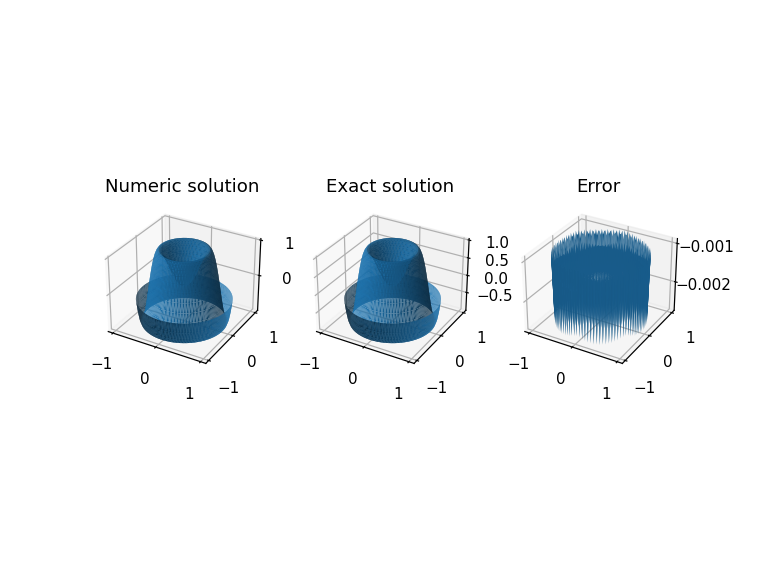

Text(0.5, 0.92, 'Error')

In [19]:
N = 1000

#Running the profiler
#cProfile.run("Laplace2DSolverP2(N, f)", sort="tottime")

# Computing our approximate solution
p,tri,edge = GetDisc(N)
pnew, trinew, edgenew, boundary_middle_nodes = T6_elements(p, tri, edge)
u = Laplace2DSolverP2(N, f_disc)

boundary = np.unique(edge.flatten())
points = np.delete(pnew, np.concatenate([boundary,boundary_middle_nodes]), axis=0)

u_w_boundary = np.zeros(len(pnew))
u_w_boundary[:len(p)-len(edge)] = u[:len(p)-len(edge)]
idx = np.arange(len(p),len(pnew))
idx = np.setdiff1d(idx,boundary_middle_nodes)
u_w_boundary[idx] = u[len(p)-len(edge):]

fig, ax = plt.subplots(1,3,subplot_kw={"projection": "3d"})
ax[0].plot_trisurf(points[:,0],points[:,1],u)
ax[0].set_title('Numeric solution')
#fig.savefig('2_8_numeric.pdf')

u_exact = u_ex_disc(points[:,0], points[:,1])

ax[1].plot_trisurf(points[:,0],points[:,1],u_exact)
ax[1].set_title('Exact solution')


#Plotting the difference.
ax[2].plot_trisurf(points[:,0],points[:,1],u_exact-u)
ax[2].set_title('Error')
#fig.savefig('2_8_error.pdf')

## Neumann for P1 elements

### Quadratures

In [20]:
def quadrature1D(a, b, Nq, g):
    # Function which performs quadrature in 1D
    # of function g over the interval [a,b] with
    # Nq quadrature points where Nq = 1, 2, 3, or 4

    # Calculating half of the interval length
    h = (b-a)/2
    zq = np.array([-np.sqrt(3/5),0,np.sqrt(3/5)])
    pq = np.array([5/9,8/9,5/9])
        
    return h * sum(pq * g(h*zq+(a+b)/2))

In [21]:
def quadrature2D(p1,p2,p3, Nq, g):
    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]])
    pq = np.ones(3)/3

    #J = np.absolute(np.cross(p1-p3,p2-p3)) #Endrer np.linalg.norm til np.absolute, siden vi får ut skalarer.
    J = cross_product(p1,p2,p3) #Raskere enn np.cross
    #coords = np.outer(zq[:,0],p1) + np.outer(zq[:,1],p2) + np.outer(zq[:,2],p3 )
    x = zq[:,0]*p1[0] + zq[:,1]*p2[0] + zq[:,2]*p3[0]
    y = zq[:,0]*p1[1] + zq[:,1]*p2[1] + zq[:,2]*p3[1]
    
    #I = J/2 * np.sum(pq * g(coords[:,0],coords[:,1]))
    I = J/2 * sum(pq * g(x,y))
    return I

In [22]:
def linequadrature2D(a,b,Nq,g):
    #Takes two points a and b in 2D, Nq which is the number of interpolation points, and a function g. 
    #Returns the straight-line integral from a to b of g. 
    
    #These quanteties are discribed in the report. 
    norm = (1/2)*np.sqrt((b[0]-a[0])**2+(b[1]-a[1])**2)
    
    def x(t): 
        return (1/2)*((1-t)*a[0] + (t+1)*b[0])
    def y(t): 
        return (1/2)*((1-t)*a[1] + (t+1)*b[1])
    def f(t):
        return g(x(t), y(t))
    
    u = lambda t: f(t) 
    
    return norm*quadrature1D(-1, 1, Nq, u)

### Neumann

In [23]:
def g(x,y):
    return 4*np.pi*np.sqrt(x**2+y**2)*np.cos(2*np.pi*(x**2+y**2)) 

In [24]:
def isNeumann(p,idx):
     return p[idx][1]>0 #here one can choose if >=0 or >0

In [25]:
def LoadVectorNeumann(N,p,tri,edge, f, g):

    F = np.zeros(N)
    res = np.zeros(N)

    for k in range(len(tri)):
        C = np.linalg.solve([[1,p[tri[k,0],0],p[tri[k,0],1]],
                             [1,p[tri[k,1],0],p[tri[k,1],1]],
                             [1,p[tri[k,2],0],p[tri[k,2],1]]],
                            np.identity(3))
        for alpha in range(3):
            i = tri[k, alpha]

            
            def H_ak(x,y):
                return C[0,alpha] + C[1,alpha]*x + C[2,alpha]*y
            def fH_ak(x,y):
                return f(x,y)*H_ak(x,y)  
            

            h = lambda x,y: fH_ak(x,y)

            F[i] = F[i] + quadrature2D(p[tri[k,0]], p[tri[k,1]], p[tri[k,2]], 3, h)

    for e in edge:

        idx_1 = e[0]

        idx_2 = e[1]

        if isNeumann(p,idx_1) and isNeumann(p,idx_2):

            if isNeumann(p,idx_1):

                res[idx_1] += linequadrature2D(p[idx_1],p[idx_2],3,g)/2

            if isNeumann(p,idx_2):
                res[idx_2] += linequadrature2D(p[idx_1],p[idx_2],3,g)/2

    F = F + res

    return F

In [26]:
def Laplace2DSolverNeumann(N, f, g):
    
    p,tri,edge = GetDisc(N)
    p_tri = p[tri]
    p_tri = p_tri.reshape(-1,6)
    
    #Makes the matrix without considering the boundary
    Atilde =  StiffnessMatrixP1(p,tri,p_tri,N)

    #Makes the right hand side without considering the boundary
    Ftilde = LoadVectorNeumann(N,p,tri,edge, f, g)

    NDboundary = 0
    for i in range(N):
        if i in edge[:,0] and p[i,1] < 0:
            NDboundary += 1
    Nend = N - NDboundary
    
    #Convert our sparse matrix to another format
    spAtilde = scipy.sparse.csr_matrix(Atilde)
    
    #Slicing away the boundary points
    spA = spAtilde[:Nend, :Nend]
    F = Ftilde[:Nend]
    
    #Solve the system
    u = scipy.sparse.linalg.spsolve(spA,F)

    return u

## Error Estimates in The Energy Norm

In [27]:
def cross_product(p1, p2, p3):
    P = p1-p3
    Q = p2-p3
    cross = P[0]*Q[1]-P[1]*Q[0]
    absolute = abs(cross)
    return absolute

In [28]:
def EnergyErrorP1(p,tri,u_grad,uh):

    error = 0
    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]]) # Definining the interpolation points
    pq = np.ones(3)/3
    
    for element in tri:

        p1 = p[element[0]]
        p2 = p[element[1]]
        p3 = p[element[2]]
        
        area = 1/2 * cross_product(p1,p2,p3)
          
        # Finding the cartesian coordinates x,y for the points to evaluate the integrand at
        x = p1[0]*zq[:,0] + p2[0]*zq[:,1] + p3[0]*zq[:,2]
        y = p1[1]*zq[:,0] + p2[1]*zq[:,1] + p3[1]*zq[:,2]
            
        xi = p1[0]; xj = p2[0]; xm = p3[0]
        yi = p1[1]; yj = p2[1]; ym = p3[1]
        
        beta = [yj - ym, ym - yi, yi-yj]/(2*area)
        gamma = [xm - xj, xi - xm, xj-xi]/(2*area)
        
        grad_uh = np.zeros((2,3))
        
        for j, alpha in enumerate(element):
            
            grad_uh_j = np.array([beta[j],gamma[j]])
            grad_uh += np.repeat(grad_uh_j, 3).reshape(2,-1)*uh[alpha]
            
        integral =  area * np.sum( pq*((grad_uh[0,:]-u_grad(x,y)[0])**2 + (grad_uh[1,:]-u_grad(x,y)[1])**2))
        error += integral
            
    return np.sqrt(error)

In [29]:
def EnergyErrorP2(pnew,trinew,u_grad,uh):

    error = 0
    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]]) # Definining the interpolation points
    pq = np.ones(3)/3
        
    for element in trinew:

        p1 = pnew[element[0]]
        p2 = pnew[element[1]]
        p3 = pnew[element[2]]
        
        area = 1/2 * cross_product(p1,p2,p3)
          
        # Finding the cartesian coordinates x,y for the points to evaluate the integrand at
        x = p1[0]*zq[:,0] + p2[0]*zq[:,1] + p3[0]*zq[:,2]
        y = p1[1]*zq[:,0] + p2[1]*zq[:,1] + p3[1]*zq[:,2]
        
        grad_uh = np.zeros((2,3))
        
        for j, alpha in enumerate(element):
            Nxj = gradients(p1,p2,p3, j, 'x')
            Nyj = gradients(p1,p2,p3, j, 'y')
            
            grad_uh += np.array([Nxj(x,y),Nyj(x,y)])*uh[alpha]
            
        error +=  area * np.sum( pq*((grad_uh[0,:]-u_grad(x,y)[0])**2 + (grad_uh[1,:]-u_grad(x,y)[1])**2))
            
    return np.sqrt(error)

In [30]:
u_grad_disc = lambda x,y: 4*np.pi*np.cos(2*np.pi*(x**2+y**2))*np.array([x,y])

In [31]:
N = np.array([20,100,1000,5000,10000]) #np.array([10,100,1000,5000,10000])

error_dirichlet = np.zeros(len(N))
error_neumann = np.zeros(len(N))

for i in range(len(N)):

        p,tri,edge = GetDisc(N[i])

        u_dirichlet = Laplace2DSolverP1(N[i], f_disc)
        u_w_boundary_dirichlet = np.zeros(len(p))
        u_w_boundary_dirichlet[:len(u_dirichlet)] = u_dirichlet
        error_dirichlet[i] = EnergyErrorP1(p,tri,u_grad_disc,u_w_boundary_dirichlet)

        u_neumann = Laplace2DSolverNeumann(N[i], f_disc, g)
        u_w_boundary_neumann = np.zeros(len(p))
        u_w_boundary_neumann[:len(u_neumann)] = u_neumann
        error_neumann[i] = EnergyErrorP1(p,tri,u_grad_disc,u_w_boundary_neumann)

<IPython.core.display.Javascript object>


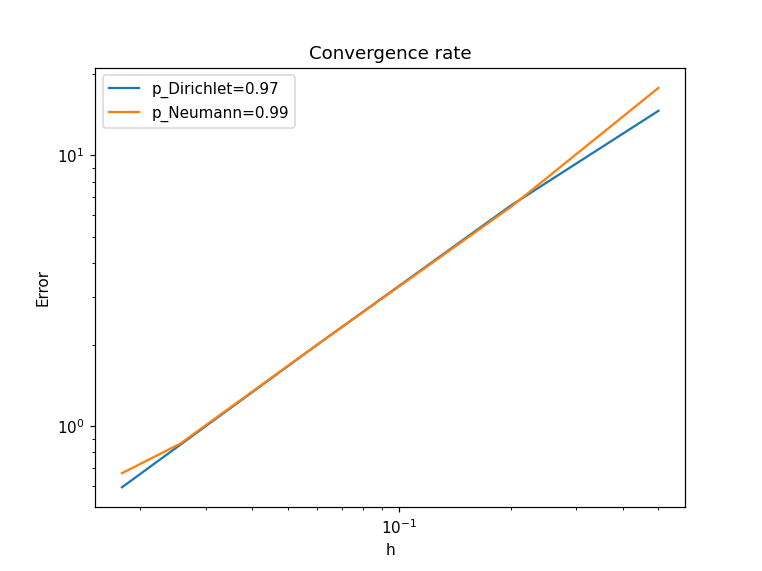

In [32]:
M  = np.floor(np.sqrt(N/np.pi))
hs = 1/M

fig, ax = plt.subplots()
ax.loglog(hs,error_dirichlet,label='p_Dirichlet={:.2f}'.format(np.polyfit(np.log(hs),np.log(error_dirichlet),1)[0]))
ax.loglog(hs,error_neumann,label='p_Neumann={:.2f}'.format(np.polyfit(np.log(hs),np.log(error_neumann),1)[0]))
ax.legend()
ax.set_title('Convergence rate')
ax.set_xlabel('h')
ax.set_ylabel('Error')


fig.savefig('convergence_rate_p1.pdf')

### Comparison to reference solution

In [33]:
def barycentric(coords,triangle):
    
    A = np.array([[triangle[1,0]-triangle[0,0],triangle[2,0]-triangle[0,0]],[triangle[1,1]-triangle[0,1],triangle[2,1]-triangle[0,1]]])
    s,t = np.linalg.solve(A,coords-triangle[0])
    
    if s<=1 and t<=1 and s>=0 and t>=0 and s+t>=0 and s+t<=1:
        return True
    else:
        return False

In [34]:
def EnergyErrorP1Ref(p,tri,uh,p_ref,tri_ref,uh_ref):

    error = 0
    
    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]]) # Definining the interpolation points
    pq = np.ones(3)/3

    for element_ref in tri_ref:

        p1_ref = p_ref[element_ref[0]]
        p2_ref = p_ref[element_ref[1]]
        p3_ref = p_ref[element_ref[2]]
        
        area_ref = 1/2 * cross_product(p1_ref,p2_ref,p3_ref)
            
        xi_ref = p1_ref[0]; xj_ref = p2_ref[0]; xm_ref = p3_ref[0]
        yi_ref = p1_ref[1]; yj_ref = p2_ref[1]; ym_ref = p3_ref[1]
        
        beta_ref = [yj_ref - ym_ref, ym_ref - yi_ref, yi_ref-yj_ref]/(2*area_ref)
        gamma_ref = [xm_ref - xj_ref, xi_ref - xm_ref, xj_ref-xi_ref]/(2*area_ref)
        
        grad_uh_ref = np.zeros((2,3))
        
        for j, alpha in enumerate(element_ref):
            
            grad_uh_j_ref = np.array([beta_ref[j],gamma_ref[j]])
            grad_uh_ref += np.repeat(grad_uh_j_ref, 3).reshape(2,-1)*uh_ref[alpha]
            
        centre = np.sum(p_ref[element_ref],0)/3
        
        for l, element in enumerate(tri):
            if barycentric(centre,p[element]):
                
                p1 = p[element[0]]
                p2 = p[element[1]]
                p3 = p[element[2]]

                area = 1/2 * cross_product(p1,p2,p3)

                grad_uh = np.zeros((2,3))

                xi = p1[0]; xj = p2[0]; xm = p3[0]
                yi = p1[1]; yj = p2[1]; ym = p3[1]

                beta = [yj - ym, ym - yi, yi-yj]/(2*area)
                gamma = [xm - xj, xi - xm, xj-xi]/(2*area)

                for j, phi in enumerate(element):
                    grad_uh_j = np.array([beta[j],gamma[j]])
                    grad_uh += np.repeat(grad_uh_j,3).reshape(2,-1)*uh[phi]
    
                error +=  area_ref * np.sum( pq*((grad_uh[0,:]-grad_uh_ref[0,:])**2 + (grad_uh[1,:]-grad_uh_ref[1,:])**2))

    return np.sqrt(error)

In [35]:
def energynorm(p,tri,uh):
    
    integral = 0
    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]]) # Definining the interpolation points
    pq = np.ones(3)/3
        
    for element in tri:

        p1 = p[element[0]]
        p2 = p[element[1]]
        p3 = p[element[2]]
        
        # Finding the cartesian coordinates x,y for the points to evaluate the integrand at
        x = p1[0]*zq[:,0] + p2[0]*zq[:,1] + p3[0]*zq[:,2]
        y = p1[1]*zq[:,0] + p2[1]*zq[:,1] + p3[1]*zq[:,2]
            
        xi = p1[0]; xj = p2[0]; xm = p3[0]
        yi = p1[1]; yj = p2[1]; ym = p3[1]
        
        area = 1/2 * cross_product(p1,p2,p3)
        
        beta = [yj - ym, ym - yi, yi-yj]/(2*area)
        gamma = [xm - xj, xi - xm, xj-xi]/(2*area)
        
        grad_uh = np.zeros((2,3))
        
        for j, alpha in enumerate(element):
            
            grad_uh_j = np.array([beta[j],gamma[j]])
            grad_uh += np.repeat(grad_uh_j, 3).reshape(2,-1)*uh[alpha]
            
        integral +=  area * np.sum( pq*(grad_uh[0,:]**2 + grad_uh[1,:]**2))
    
    return np.sqrt(integral)

In [36]:
def Laplace2DSolverPlate(N, f):
    
    p,tri,edge = getPlate(N)
    
    p_tri = p[tri]
    p_tri = p_tri.reshape(-1,6)

    #Makes the matrix without considering the boundary
    Atilde =  StiffnessMatrixP1(p,tri,p_tri,N**2)
    
    #Makes the right hand side without considering the boundary
    Ftilde = LoadVectorP1(p,tri,p_tri,N**2, f)
    
    #Define the reduced system 
    a = np.zeros(N**2,dtype = int)
    a[:N] = 1
    a[-N:] = 1
    a[::N] = 1
    a[N-1::N] = 1
    b = np.logical_not(a)

    #Convert our sparse matrix to another format
    spAtilde = scipy.sparse.csr_matrix(Atilde)
    
    #Slicing away the boundary points
    spA = spAtilde[b, :]
    spA = spA[:, b]
    F = Ftilde[b]
    
    #Solve the system
    u = scipy.sparse.linalg.spsolve(spA,F)
    
    return u

In [37]:
def f_plate(x,y):
    return -(2*(x**2+y**2)-4)

In [38]:
def u_grad_plate(x,y):
    return 2*np.array([x*(y**2-1),y*(x**2-1)])

In [39]:
Ns = np.array([3,3*2,3*2**2,3*2**3])+1 #Ns = np.array([4,7,13,24])
N_ref = 3*2**4+1#129#33 #65 #N_ref = 92

print("begynner ref")
uh_ref_dirichlet = Laplace2DSolverPlate(N_ref, f_plate)
uh_ref = np.zeros((N_ref,N_ref))
uh_ref[1:-1,1:-1] = uh_ref_dirichlet.reshape(N_ref-2,N_ref-2)
uh_ref = uh_ref.reshape(-1)
p_ref,tri_ref,edge_ref = getPlate(N_ref)
print('ferdig ref')
print('begynner norm, ref')
norm = energynorm(p_ref,tri_ref,uh_ref)
print('ferdig norm, ref')

error = np.zeros(len(Ns))

for k,N in enumerate(Ns):
        print(f"{k} of {len(Ns)}")

        p,tri,edge = getPlate(N)

        u_dirichlet = Laplace2DSolverPlate(N, f_plate)
        uh = np.zeros((N,N))
        uh[1:-1,1:-1] = u_dirichlet.reshape(N-2,N-2)
        uh = uh.reshape(-1)
        
        error[k] = EnergyErrorP1Ref(p,tri,uh,p_ref,tri_ref,uh_ref)/norm

begynner ref
ferdig ref
begynner norm, ref
ferdig norm, ref
0 of 4
1 of 4
2 of 4


KeyboardInterrupt: 

In [ ]:
hs = np.sqrt(2)/(Ns-1)#2*np.sqrt(2)/(Ns-1)

fig, ax = plt.subplots(constrained_layout=True)
ax.loglog(hs,error/norm,label='p_Dirichlet={:.2f}'.format(np.polyfit(np.log(hs),np.log(error/norm),1)[0]))
ax.set_title('Convergence rate')
ax.set_xlabel('h')
ax.set_ylabel('Relative error in energy norm')
ax.legend()
fig.show()
fig.savefig('fig2.pdf')

In [ ]:
print(hs)
print(1/np.array([2,2**2,2**3,2**4]))

<IPython.core.display.Javascript object>


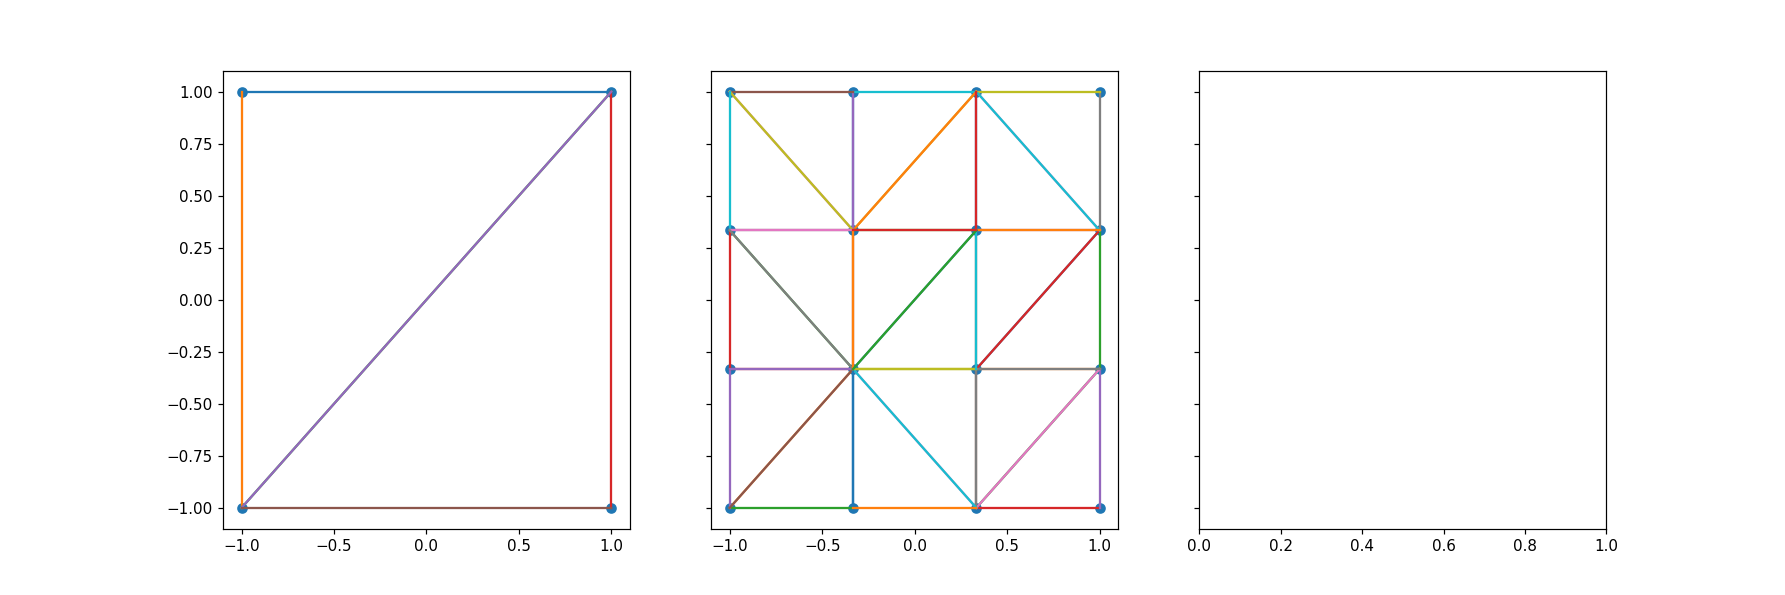

In [40]:
sizes = [2,4]

fig, ax = plt.subplots(1,3,sharey = True,figsize=(15, 5)) 

for i in range(len(sizes)):
    
    p,tri,edge = getPlate(sizes[i])
    
    ax[i].scatter(p[:,0],p[:,1])
    
    # Plot of the lines in the triangulation
    for j in range(len(tri)):
        ax[i].plot([p[tri[j,0],0],p[tri[j,1],0]],[p[tri[j,0],1],p[tri[j,1],1]])
        ax[i].plot([p[tri[j,2],0],p[tri[j,1],0]],[p[tri[j,2],1],p[tri[j,1],1]])
        ax[i].plot([p[tri[j,0],0],p[tri[j,2],0]],[p[tri[j,0],1],p[tri[j,2],1]])

## Convergence for P2 elements

In [41]:
def gradients(p1, p2, p3, i, partial):
    xi = p1[0]; xj = p2[0]; xm = p3[0]
    yi = p1[1]; yj = p2[1]; ym = p3[1]

    #Computing the coeffients for our nodal basis functions
    alphai = xj*ym-yj*xm; alphaj = xm*yi - ym*xi; alpham = xi*yj - yi*xj
    betai = yj - ym; betaj = ym - yi; betam = yi-yj
    gammai = xm - xj; gammaj = xi - xm; gammam = xj-xi

    A = 1/2 * cross_product(p1,p2,p3) #Area
    
    N1x = lambda x,y: 1/A**2 * (alphai*betai + betai*betai*x + gammai*betai*y) - betai / (2*A)
    N2x = lambda x,y: 1/A**2 * (alphaj*betaj + betaj*betaj*x + gammaj*betaj*y) - betaj / (2*A)
    N3x = lambda x,y: 1/A**2 * (alpham*betam + betam*betam*x + gammam*betam*y) - betam / (2*A)
    N4x = lambda x,y: 1/A**2 * (alphaj*betai + betaj*betai*x + gammaj*betai*y) + 1/A**2 * (alphai*betaj + betai*betaj*x + gammai*betaj*y)
    N5x = lambda x,y: 1/A**2 * (alpham*betaj + betam*betaj*x + gammam*betaj*y) + 1/A**2 * (alphaj*betam + betaj*betam*x + gammaj*betam*y)
    N6x = lambda x,y: 1/A**2 * (alpham*betai + betam*betai*x + gammam*betai*y) + 1/A**2 * (alphai*betam + betai*betam*x + gammai*betam*y)

    N1y = lambda x,y: (1/(A**2)) * (alphai*gammai + betai*gammai*x + gammai*gammai*y) - gammai / (2*A)
    N2y = lambda x,y: (1/(A**2)) * (alphaj*gammaj + betaj*gammaj*x + gammaj*gammaj*y) - gammaj / (2*A)
    N3y = lambda x,y: (1/(A**2)) * (alpham*gammam + betam*gammam*x + gammam*gammam*y) - gammam / (2*A)
    N4y = lambda x,y: (1/(A**2)) * (alphaj*gammai + betaj*gammai*x + gammaj*gammai*y) + 1/A**2 * (alphai*gammaj + betai*gammaj*x + gammai*gammaj*y)
    N5y = lambda x,y: (1/(A**2)) * (alpham*gammaj + betam*gammaj*x + gammam*gammaj*y) + 1/A**2 * (alphaj*gammam + betaj*gammam*x + gammaj*gammam*y)
    N6y = lambda x,y: (1/(A**2)) * (alpham*gammai + betam*gammai*x + gammam*gammai*y) + 1/A**2 * (alphai*gammam + betai*gammam*x + gammai*gammam*y)
    
    if partial == 'x':
        if i == 0:
            func = N1x
        elif i == 1:
            func = N2x
        elif i == 2:
            func = N3x
        elif i == 3:
            func = N4x
        elif i == 4:
            func = N5x
        elif i == 5:
            func = N6x
    elif partial == 'y':
        if i == 0:
            func = N1y
        elif i == 1:
            func = N2y
        elif i == 2:
            func = N3y
        elif i == 3:
            func = N4y
        elif i == 4:
            func = N5y
        elif i == 5:
            func = N6y
    return func

In [63]:
Ns = np.array([20,100,1000,5000,10000,50000]) #np.array([10,100,1000,5000,10000])

error_P2 = np.zeros(len(Ns))
error_P2_max = np.zeros(len(Ns))

for i,N in enumerate(Ns):

        p,tri,edge = GetDisc(N)
        pnew, trinew, edgenew, boundary_middle_nodes = T6_elements(p, tri,edge)

        u_dirichlet = Laplace2DSolverP2(N, f_disc)
        
        boundary = np.unique(edge.flatten())
        points = np.delete(pnew, np.concatenate([boundary,boundary_middle_nodes]), axis=0)

        uh = np.zeros(len(pnew))
        uh[:len(p)-len(edge)] = u_dirichlet[:len(p)-len(edge)]
        idx = np.arange(len(p),len(pnew))
        idx = np.setdiff1d(idx,boundary_middle_nodes)
        uh[idx] = u_dirichlet[len(p)-len(edge):]
        
        error_P2[i] = EnergyErrorP2(pnew,trinew,u_grad_disc,uh)
        error_P2_max[i] = np.max(np.abs(uh - u_ex_disc(pnew[:,0],pnew[:,1])))
        print(error_P2)
        print(error_P2_max)
        
unew = uh

Starting solving the matrix system
Completed solving the matrix system
[13.70945946  0.          0.          0.          0.          0.        ]
[0.76525495 0.         0.         0.         0.         0.        ]
Starting solving the matrix system
Completed solving the matrix system
[13.70945946  2.55478455  0.          0.          0.          0.        ]
[0.76525495 0.07320208 0.         0.         0.         0.        ]
Starting solving the matrix system
Completed solving the matrix system
[13.70945946  2.55478455  0.27323235  0.          0.          0.        ]
[0.76525495 0.07320208 0.00273021 0.         0.         0.        ]
Starting solving the matrix system
Completed solving the matrix system
[13.70945946  2.55478455  0.27323235  0.05268287  0.          0.        ]
[7.65254946e-01 7.32020776e-02 2.73020752e-03 4.70603881e-04
 0.00000000e+00 0.00000000e+00]
Starting solving the matrix system
Completed solving the matrix system
[13.70945946  2.55478455  0.27323235  0.05268287  0.

<IPython.core.display.Javascript object>


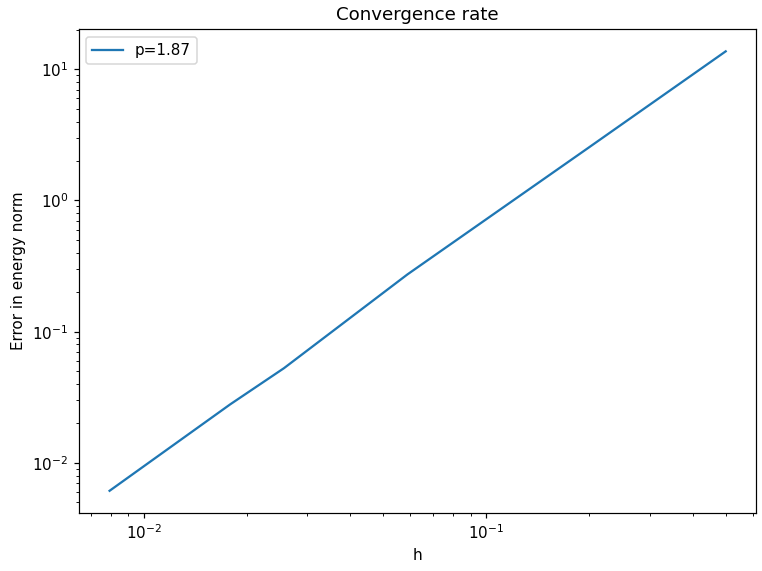

In [64]:
M  = np.floor(np.sqrt(Ns/np.pi))
hs = 1/M

fig, ax = plt.subplots(constrained_layout=True)
ax.loglog(hs,error_P2,label='p={:.2f}'.format(np.polyfit(np.log(hs),np.log(error_P2),1)[0]))
ax.set_title('Convergence rate')
ax.set_xlabel('h')
ax.set_ylabel('Error in energy norm')
ax.legend()
fig.show()
fig.savefig('P2_convergence.pdf')

# L SHAPE

In [43]:
def g1(x,y):
    
    theta = np.mod(np.arctan2(y,x), 2*np.pi)
    theta[theta==0] = 2*np.pi
    
    return 2/3*(y*np.sin(2/3*(theta+np.pi))+x*np.cos((2/3)*(theta+np.pi)))/(x**2+y**2)**(2/3)

def g2(x,y):
    
    theta = np.mod(np.arctan2(y,x), 2*np.pi)
    theta[theta==0] = 2*np.pi
    
    return 2/3*(x*np.sin(2/3*(theta+np.pi))-y*np.cos((2/3)*(theta + np.pi)))/(x**2+y**2)**(2/3)
    

def g3(x,y):
    
    theta = np.mod(np.arctan2(y,x), 2*np.pi)
    theta[theta==0] = 2*np.pi
    
    return -2/3*(y*np.sin(2/3*(theta+np.pi))+x*np.cos((2/3)*(theta+np.pi)))/(x**2+y**2)**(2/3)

def g4(x,y):
    
    theta = np.mod(np.arctan2(y,x), 2*np.pi)
    theta[theta==0] = 2*np.pi
    
    return -2/3*(x*np.sin(2/3*(theta+np.pi))-y*np.cos((2/3)*(theta + np.pi)))/(x**2+y**2)**(2/3)

In [44]:
def for_loop_load_vector(N,pnew,trinew,edgenew,f):
    M = len(pnew)
    F = np.zeros(M)
    
    Nboundary1 = []
    Nboundary2 = []
    Nboundary3 = []
    Nboundary4 = []
    for i, point in enumerate(pnew):
        if point[1]>=1:
            Nboundary1.append(i)
        if point[0]>=1:
            Nboundary2.append(i)
        if point[1]<=-1:
            Nboundary3.append(i)
        if point[0]<=-1:
            Nboundary4.append(i)
            
    Nboundary = [Nboundary1, Nboundary2, Nboundary3, Nboundary4]
    g = [g1, g2, g3, g4]
    
    func = lambda g,h: lambda x,y: g(x,y)*h(x,y)

    for element in trinew:
        p1 = pnew[element[0]]
        p2 = pnew[element[1]]
        p3 = pnew[element[2]]
        
        area = 1/2 * cross_product(p1,p2,p3)
        #Let us define the quadrature points
        zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]]) # Definining the interpolation points
        pq = np.ones(3)/3
        
        #zq = np.array([[1/3, 1/3, 1/3], [3/5, 1/5, 1/5], [1/5, 3/5, 1/5], [1/5, 1/5, 3/5]])
        #pq = np.array([-9/16, 25/48, 25/48, 25/48])
        
        # Finding the cartesian coordinates x,y for the points to evaluate the integrand at
        x = p1[0]*zq[:,0] + p2[0]*zq[:,1] + p3[0]*zq[:,2]
        y = p1[1]*zq[:,0] + p2[1]*zq[:,1] + p3[1]*zq[:,2]
        for j, alpha in enumerate(element):
            Ni = nodal_basis(p1,p2,p3, j)
            integral =  area * np.sum( pq*f(x,y)*Ni(x,y))
            F[alpha] += integral
            
    for element in trinew:
        edge1 = [element[0], element[1]]
        edge2 = [element[1], element[2]]
        edge3 = [element[2], element[0]]
        
        p1 = pnew[element[0]]
        p2 = pnew[element[1]]
        p3 = pnew[element[2]]
        for i, edge in enumerate([edge1, edge2, edge3]):
            for j, (boundaryi, gi) in  enumerate(zip(Nboundary, g)):# j important to know along which boundary we are
                if (edge[0] in boundaryi) and (edge[1] in boundaryi):
                    if i==0:
                        #Blir nodal basis til 0, 1, 3
                        F[edge[0]] += linequadrature2D(pnew[edge[0]],pnew[edge[1]],3,func(gi,nodal_basis(p1,p2,p3,i)))  
                        F[edge[1]] += linequadrature2D(pnew[edge[0]],pnew[edge[1]],3,func(gi,nodal_basis(p1,p2,p3,i+1)))  
                        F[element[3+i]] += linequadrature2D(pnew[edge[0]],pnew[edge[1]],3,func(gi,nodal_basis(p1,p2,p3,i+3)))  
                    elif i==1:
                        #Blir nodal basis til 1,2,4
                        F[edge[0]] += linequadrature2D(pnew[edge[0]],pnew[edge[1]],3,func(gi,nodal_basis(p1,p2,p3,i)))  
                        F[edge[1]] += linequadrature2D(pnew[edge[0]],pnew[edge[1]],3,func(gi,nodal_basis(p1,p2,p3,i+1)))  
                        F[element[3+i]] += linequadrature2D(pnew[edge[0]],pnew[edge[1]],3,func(gi,nodal_basis(p1,p2,p3,i+3)))  
                        
                    elif i==2:
                        #Blir nodal basis til 2,0, 5
                        F[edge[0]] += linequadrature2D(pnew[edge[0]],pnew[edge[1]],3,func(gi,nodal_basis(p1,p2,p3,i)))  
                        F[edge[1]] += linequadrature2D(pnew[edge[0]],pnew[edge[1]],3,func(gi,nodal_basis(p1,p2,p3,i-2)))  
                        F[element[3+i]] += linequadrature2D(pnew[edge[0]],pnew[edge[1]],3,func(gi,nodal_basis(p1,p2,p3,i+3)))  
    return F

In [45]:
def Laplace2DSolverLShape(N,f):
    p,tri,edge = GetLShape(N)
    p1, tri1, edge1, boundary_middle_nodes = T6_elements(p, tri, edge)
    
    
    N_dirichlet = np.zeros(len(pnew),dtype=bool)

    id_1 = np.array([pnew[:,0]==0])[0]
    id_2 = np.array([pnew[:,1]<=1])[0]
    id_3 = np.array([0<=pnew[:,1]])[0]
    N_dirichlet[id_1*id_2*id_3] = True

    id_1 = np.array([pnew[:,1]==0])[0]
    id_2 = np.array([pnew[:,0]<=1])[0]
    id_3 = np.array([0<=pnew[:,0]])[0]
    N_dirichlet[id_1*id_2*id_3] = True
    
    #Makes the matrix without considering the boundary
    Atilde =  StiffnessMatrixP2(p, tri, p1, tri1)
    
    #Makes the right hand side without considering the boundary
    Ftilde = for_loop_load_vector(N,p1,tri1,edge1,f)
    
    #Convert our sparse matrix to another format
    spAtilde = scipy.sparse.csr_matrix(Atilde)
    
    #Removing boundary nodes
    A = delete_rows_csr(spAtilde, N_dirichlet)
    spA = delete_cols_csr(A, N_dirichlet)
    
    #np.delete should work fine for this numpy array 
    F = np.delete(Ftilde, N_dirichlet)
    
    #Solve the system
    u = scipy.sparse.linalg.spsolve(spA,F)
    
    return u

In [46]:
def Dirichlet_boundary(pnew):
    N_dirichlet = np.zeros(len(pnew),dtype=bool)
    id_1 = np.array([pnew[:,0]==0])[0]
    id_2 = np.array([pnew[:,1]<=1])[0]
    id_3 = np.array([0<=pnew[:,1]])[0]
    N_dirichlet[id_1*id_2*id_3] = True

    id_1 = np.array([pnew[:,1]==0])[0]
    id_2 = np.array([pnew[:,0]<=1])[0]
    id_3 = np.array([0<=pnew[:,0]])[0]
    N_dirichlet[id_1*id_2*id_3] = True

    return N_dirichlet

In [47]:
f_lshape = lambda x,y: 0
def u_ex_lshape(x,y):
    
    theta = np.mod(np.arctan2(y,x), 2*np.pi)
    theta[theta==0] = 2*np.pi
    
    return (x**2+y**2)**(1/3)*np.sin(2/3*(theta+np.pi))

In [48]:
def nodal_basis(p1,p2,p3, i):
    xi = p1[0]; xj = p2[0]; xm = p3[0]
    yi = p1[1]; yj = p2[1]; ym = p3[1]

    #Computing the coeffients for our nodal basis functions
    alphai = xj*ym-yj*xm; alphaj = xm*yi - ym*xi; alpham = xi*yj - yi*xj
    betai = yj - ym; betaj = ym - yi; betam = yi-yj
    gammai = xm - xj; gammaj = xi - xm; gammam = xj-xi

    A = 1/2 * cross_product(p1,p2,p3) #Area
    
    #Need nodal functions for T6 elements
    N1 = lambda x,y: 1 / (2*A) * (alphai + betai*x + gammai*y) * (1/A * (alphai + betai*x + gammai*y) - 1)
    N2 = lambda x,y: 1 / (2*A) * (alphaj + betaj*x + gammaj*y) * (1/A * (alphaj + betaj*x + gammaj*y) - 1)
    N3 = lambda x,y: 1 / (2*A) * (alpham + betam*x + gammam*y) * (1/A * (alpham + betam*x + gammam*y) - 1)
    N4 = lambda x,y: 1 / A**2  * (alphai + betai*x + gammai*y) * (alphaj + betaj*x + gammaj*y)
    N5 = lambda x,y: 1 / A**2  * (alphaj + betaj*x + gammaj*y) * (alpham + betam*x + gammam*y)
    N6 = lambda x,y: 1 / A**2  * (alphai + betai*x + gammai*y) * (alpham + betam*x + gammam*y)
    
    if i == 0:
        func = N1
    elif i == 1:
        func = N2
    elif i == 2:
        func = N3
    elif i == 3:
        func = N4
    elif i == 4:
        func = N5
    elif i == 5:
        func = N6
    
    return func
    

In [49]:
def plot_solution_error(pnew,tri,uh,u_ex):

    fig, ax = plt.subplots(1,3,subplot_kw={"projection": "3d"},figsize=(10,5))
    ax[0].plot_trisurf(pnew[:,0],pnew[:,1],unew, triangles=tri,cmap="viridis")
    ax[0].set_title('Numeric solution')

    ax[1].plot_trisurf(pnew[:,0],pnew[:,1],u_ex(pnew[:,0], pnew[:,1]), triangles=tri,cmap="viridis")
    ax[1].set_title('Exact solution')

    ax[2].plot_trisurf(pnew[:,0],pnew[:,1],u_ex(pnew[:,0],pnew[:,1])-unew, triangles=tri,cmap="viridis")
    ax[2].set_title('Error')
    
    return fig, ax

<IPython.core.display.Javascript object>


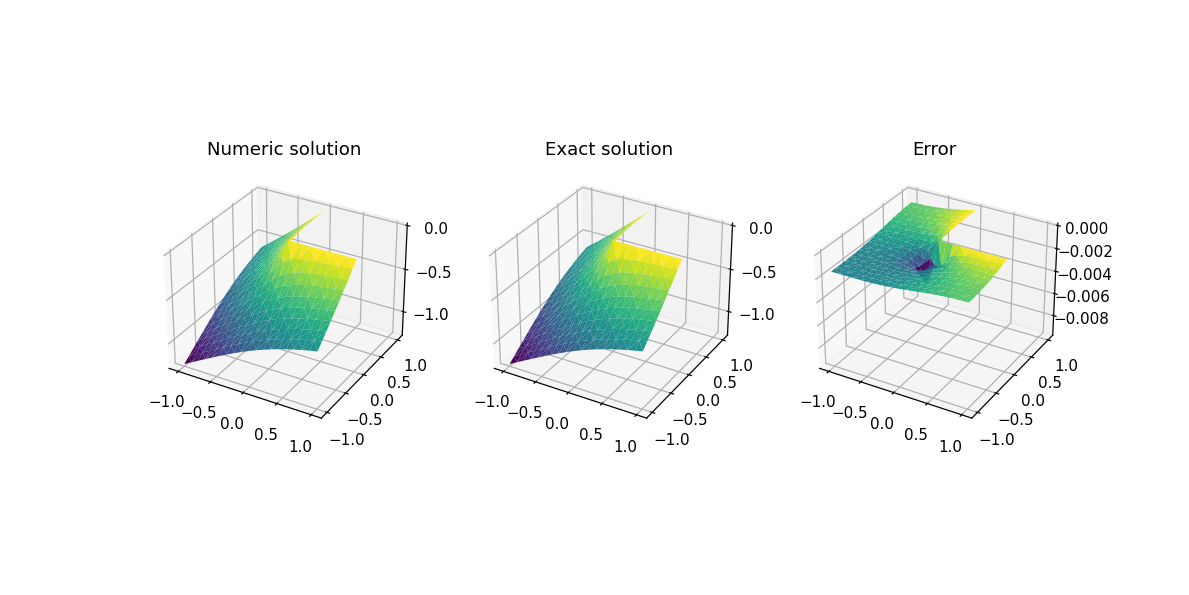

0.009604051075582695


In [50]:
N = 10

#Running the profiler
#cProfile.run("new_laplace_2d_solver(N, f)", sort="tottime")

# Computing our approximate solution
p,tri,edge = GetLShape(N)
pnew, trinew, edgenew, boundary_middle_nodes = T6_elements(p, tri, edge[:-1,:])
u = Laplace2DSolverLShape(N, f_lshape)

N_dirichlet = Dirichlet_boundary(pnew)
    
unew = np.zeros(len(pnew))
unew[~N_dirichlet] = u

fig, ax = plot_solution_error(pnew,tri,unew,u_ex_lshape)
fig.savefig('lshape_sol.pdf')

print(np.max(np.abs(u_ex_lshape(pnew[:,0],pnew[:,1])-unew)))

In [51]:
def plot_convergence(hs,error):

    fig, ax = plt.subplots()
    ax.loglog(hs,error,label='p_Dirichlet={:.2f}'.format(np.polyfit(np.log(hs),np.log(error),1)[0]))
    ax.legend()
    ax.set_title('Convergence rate')
    ax.set_xlabel('h')
    ax.set_ylabel('Error')

    return fig, ax

In [52]:
def u_grad_lshape(x,y):
    theta = np.mod(np.arctan2(y,x), 2*np.pi)
    theta[np.abs(theta)<1e-15] = 2*np.pi
    
    return 2/3*np.array([(x*np.sin(2/3*(theta+np.pi)))-y*np.cos((2/3)*(theta+np.pi)),y*np.sin(2/3*(theta+np.pi))+x*np.cos((2/3)*(theta + np.pi))])/(x**2+y**2)**(2/3)


<IPython.core.display.Javascript object>


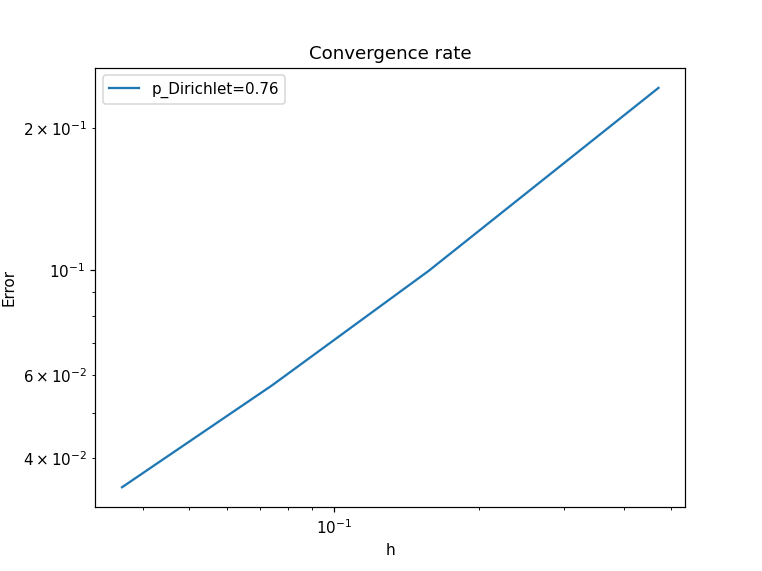

In [59]:
Ns = np.array([2,5,10,20,100])

#Running the profiler
#cProfile.run("new_laplace_2d_solver(N, f)", sort="tottime")
error = np.zeros(len(Ns))

for i, N in enumerate(Ns):

    p,tri,edge = GetLShape(N)
    pnew, trinew, edgenew, boundary_middle_nodes = T6_elements(p, tri, edge[:-1,:])
    u = Laplace2DSolverLShape(N,f_lshape)

    N_dirichlet = Dirichlet_boundary(pnew)
    
    unew = np.zeros(len(pnew))
    unew[~N_dirichlet] = u

    error[i] = EnergyErrorP2(pnew,trinew,u_grad_lshape,unew)
    
hs = np.sqrt(2)/(2*Ns-1)
fig,ax = plot_convergence(hs,error)

fig.savefig('Lshape_convergence.pdf')

### Smallest relative error

In [56]:
def energynormP2(pnew,trinew,unew):
    
    integral = 0
    zq = np.array([[1/2,1/2,0],[1/2,0,1/2],[0,1/2,1/2]]) # Definining the interpolation points
    pq = np.ones(3)/3
        
    for element in trinew:

        p1 = pnew[element[0]]
        p2 = pnew[element[1]]
        p3 = pnew[element[2]]
        
        area = 1/2 * cross_product(p1,p2,p3)
          
        # Finding the cartesian coordinates x,y for the points to evaluate the integrand at
        x = p1[0]*zq[:,0] + p2[0]*zq[:,1] + p3[0]*zq[:,2]
        y = p1[1]*zq[:,0] + p2[1]*zq[:,1] + p3[1]*zq[:,2]
        
        grad_uh = np.zeros((2,3))
        
        for j, alpha in enumerate(element):
            Nxj = gradients(p1,p2,p3, j, 'x')
            Nyj = gradients(p1,p2,p3, j, 'y')
            
            grad_uh += np.array([Nxj(x,y),Nyj(x,y)])*unew[alpha]

        integral +=  area * np.sum( pq*(grad_uh[0,:]**2 + grad_uh[1,:]**2))
    
    return np.sqrt(integral)

In [60]:
N = 150

p,tri,edge = GetLShape(N)
pnew, trinew, edgenew, boundary_middle_nodes = T6_elements(p, tri, edge[:-1,:])
u = Laplace2DSolverLShape(N,f_lshape)

N_dirichlet = Dirichlet_boundary(pnew)
    
unew = np.zeros(len(pnew))
unew[~N_dirichlet] = u

norm = energynormP2(pnew,trinew,unew)
rel_error = EnergyErrorP2(pnew,trinew,u_grad_lshape,unew)/norm

h = np.sqrt(2)/(2*N-1)

print('relative error',rel_error)
print('h',h)

relative error 0.006354205775904032
h 0.004729811245394967


In [61]:
norm

1.355053025623596

<IPython.core.display.Javascript object>


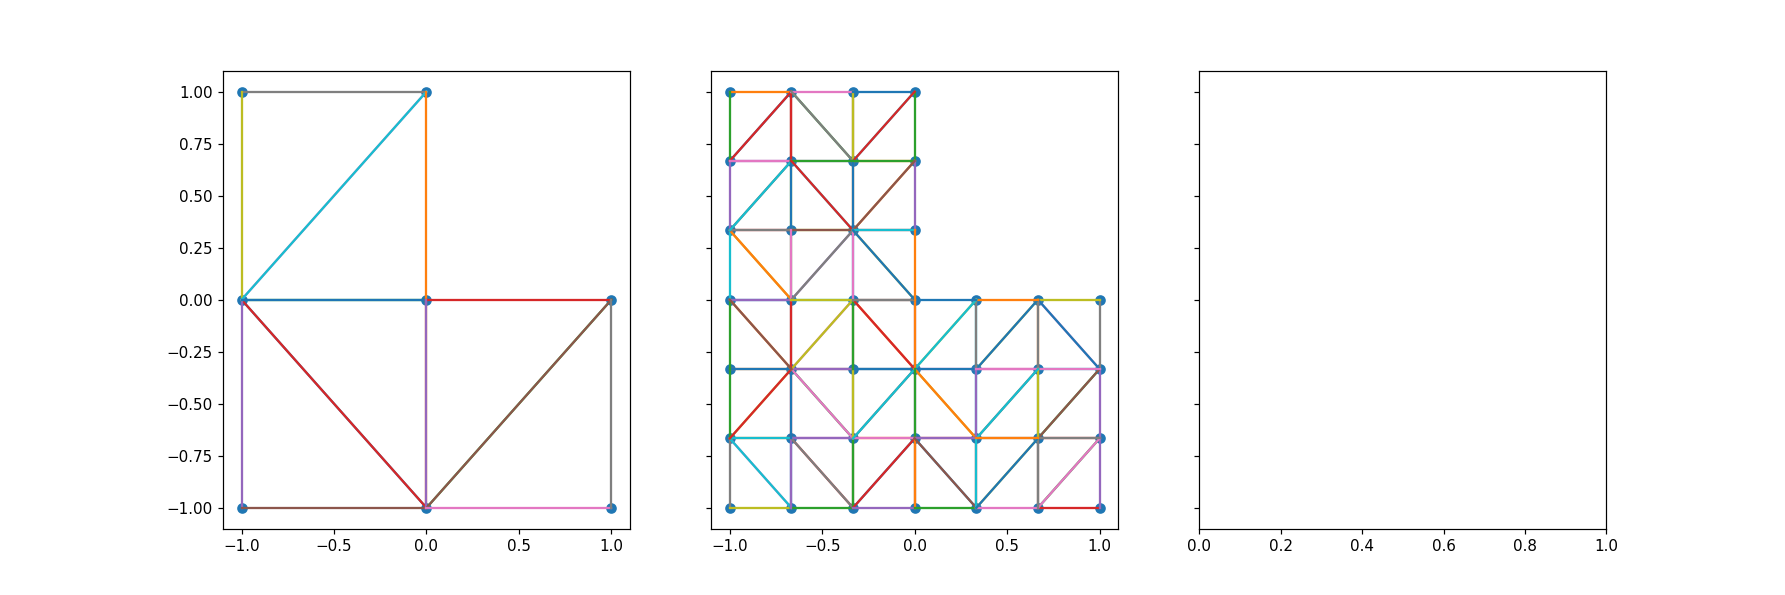

In [62]:
sizes = [2,4]

fig, ax = plt.subplots(1,3,sharey = True,figsize=(15, 5)) 

for i in range(len(sizes)):
    
    p,tri,edge = GetLShape(sizes[i])
    
    ax[i].scatter(p[:,0],p[:,1])
    
    # Plot of the lines in the triangulation
    for j in range(len(tri)):
        ax[i].plot([p[tri[j,0],0],p[tri[j,1],0]],[p[tri[j,0],1],p[tri[j,1],1]])
        ax[i].plot([p[tri[j,2],0],p[tri[j,1],0]],[p[tri[j,2],1],p[tri[j,1],1]])
        ax[i].plot([p[tri[j,0],0],p[tri[j,2],0]],[p[tri[j,0],1],p[tri[j,2],1]])